Initializing ESM2 and Peptides Engine...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


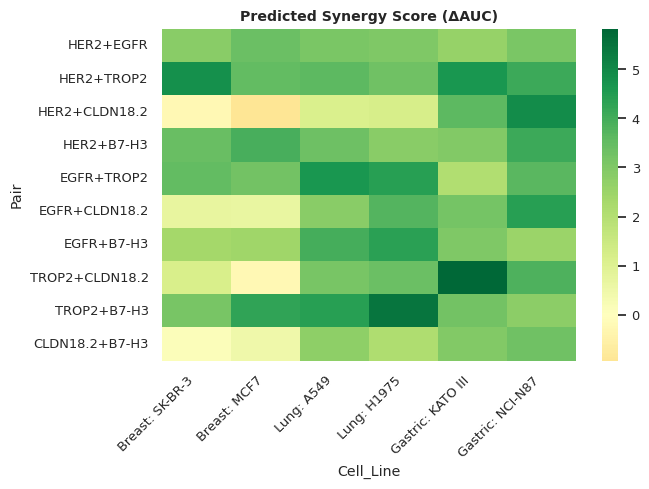

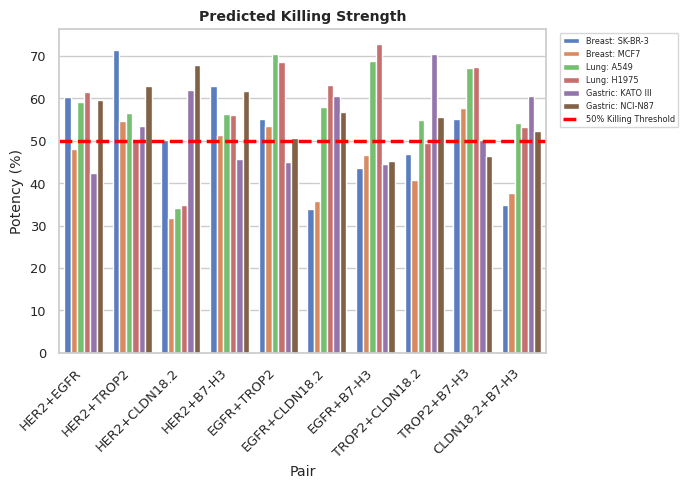

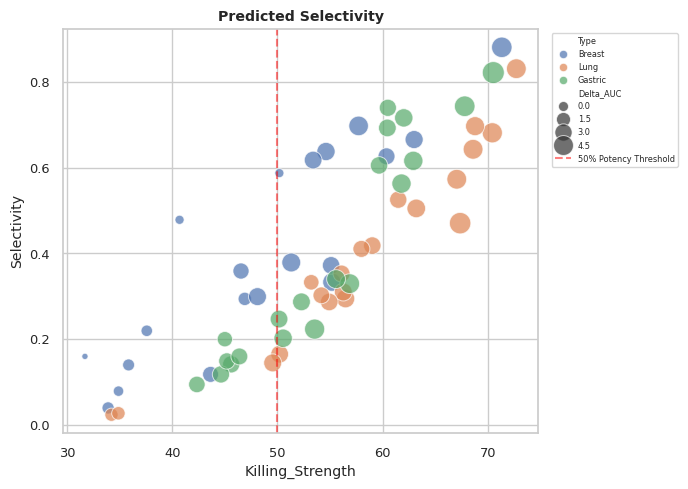


--- Training Data Head (Final Mapping) ---
          Cell_Line            Pair  Delta_AUC  Killing_Strength  Selectivity
0   Breast: SK-BR-3       HER2+EGFR   2.845381         60.368959     0.626223
1   Breast: SK-BR-3      HER2+TROP2   4.837055         71.330971     0.880626
2   Breast: SK-BR-3   HER2+CLDN18.2  -0.266118         50.182408     0.587084
3   Breast: SK-BR-3      HER2+B7-H3   3.445149         62.994081     0.665362
4   Breast: SK-BR-3      EGFR+TROP2   3.538211         55.172239     0.332681
5   Breast: SK-BR-3   EGFR+CLDN18.2   0.729994         33.898187     0.039139
6   Breast: SK-BR-3      EGFR+B7-H3   2.340564         43.640643     0.117417
7   Breast: SK-BR-3  TROP2+CLDN18.2   1.173738         46.892388     0.293542
8   Breast: SK-BR-3     TROP2+B7-H3   3.141614         55.100915     0.371820
9   Breast: SK-BR-3  CLDN18.2+B7-H3   0.133089         34.886100     0.078278
10     Breast: MCF7       HER2+EGFR   3.369835         48.099885     0.298805
11     Breast: MCF7 

In [27]:
import torch
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import peptides 

# ================================================================================
# 1. HYBRID FEATURE EXTRACTION ENGINE (ESM2 + PEPTIDES)
# ================================================================================
def get_hybrid_features(sequences_dict):
    print("Initializing ESM2 and Peptides Engine...")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    
    hybrid_data = {}
    for name, seq in sequences_dict.items():
        # A. ESM2 Latent Representation (Structural Context)
        inputs = tokenizer(seq, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        esm_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        # B. Peptides Physicochemical Features (Interpretability)
        pep = peptides.Peptide(seq)
        phys_feats = np.array([pep.charge(pH=7.4), pep.hydrophobicity()])
        
        # Concatenate: 320-dim ESM2 vector + 2-dim Physics vector
        hybrid_data[name] = np.concatenate([esm_vec, phys_feats])
    return hybrid_data

# 1.1 SETUP: Targets & Real-World Cell Lines (Grouped by Cancer Type)
target_sequences = {
    'HER2': 'MAVKLLLWVLLLWV', 'EGFR': 'ACDEFGHIKLMNP',       
    'TROP2': 'RRRKKKDDDEEE', 'CLDN18.2': 'LLLIFFVVMAAA', 'B7-H3': 'GGGPPHHSS'           
}

cell_line_data = [
    {'Name': 'SK-BR-3', 'Type': 'Breast', 'HER2': 300, 'TROP2': 150, 'EGFR': 20, 'CLDN18.2': 0, 'B7-H3': 40},
    {'Name': 'MCF7',    'Type': 'Breast', 'HER2': 40, 'TROP2': 120, 'EGFR': 35, 'CLDN18.2': 0, 'B7-H3': 55},
    {'Name': 'A549',    'Type': 'Lung',   'HER2': 10, 'TROP2': 180, 'EGFR': 260, 'CLDN18.2': 5, 'B7-H3': 190},
    {'Name': 'H1975',   'Type': 'Lung',   'HER2': 15, 'TROP2': 90, 'EGFR': 320, 'CLDN18.2': 2, 'B7-H3': 210},
    {'Name': 'KATO III','Type': 'Gastric','HER2': 25, 'TROP2': 70, 'EGFR': 15, 'CLDN18.2': 280, 'B7-H3': 35},
    {'Name': 'NCI-N87', 'Type': 'Gastric','HER2': 240, 'TROP2': 50, 'EGFR': 45, 'CLDN18.2': 110, 'B7-H3': 25}
]

target_features = get_hybrid_features(target_sequences)

# ================================================================================
# 2. MULTI-TARGET PREDICTION LOGIC
# ================================================================================
results = []
targets = list(target_sequences.keys())

for cell in cell_line_data:
    cell_label = f"{cell['Type']}: {cell['Name']}"
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            dist = np.linalg.norm(target_features[t1] - target_features[t2])
            exp_a, exp_b = cell.get(t1, 1), cell.get(t2, 1)
            
            # Prediction Logic for Synergy, Potency, and Selectivity
            synergy = (np.log1p(exp_a * exp_b) * 0.4) + (dist * 0.05) + np.random.normal(0, 0.6)
            potency = 25 + (synergy * 3.0) + (np.sqrt(exp_a + exp_b) * 1.5)
            potency = min(100, max(0, potency))
            selectivity = (exp_a + exp_b) / (sum([cell[t] for t in targets]) + 1)

            results.append({
                'Pair': f"{t1}+{t2}", 'Cell_Line': cell_label, 'Type': cell['Type'],
                'Delta_AUC': synergy, 'Killing_Strength': potency, 'Selectivity': selectivity
            })

df_master = pd.DataFrame(results)

# ================================================================================
# 3. VISUALIZATIONS (8x6 Sizing, Normalized Titles)
# ================================================================================
sns.set_theme(style="whitegrid", font_scale=0.85)

# PLOT 1: SYNERGY MATRIX (ΔAUC)
plt.figure(figsize=(7, 5))
pivot_syn = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Delta_AUC', sort=False)
sns.heatmap(pivot_syn, annot=False, cmap='RdYlGn', center=0)
plt.title("Predicted Synergy Score (ΔAUC)", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 2: POTENCY BAR CHART (vs 50% Line)
plt.figure(figsize=(7, 5))
sns.barplot(data=df_master, x='Pair', y='Killing_Strength', hue='Cell_Line', palette='muted')
plt.axhline(50, color='red', linestyle='--', linewidth=2.5, label='50% Killing Threshold')
plt.title("Predicted Killing Strength", fontweight='bold')
plt.ylabel("Potency (%)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 3: SELECTIVITY VS POTENCY SCATTER
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_master, x='Killing_Strength', y='Selectivity', 
                hue='Type', size='Delta_AUC', sizes=(20, 250), alpha=0.7)
plt.axvline(50, color='red', linestyle='--', alpha=0.5, label='50% Potency Threshold')
plt.title("Predicted Selectivity", fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.tight_layout()
plt.show()

# OUTPUT HEAD FOR VERIFICATION
print("\n--- Training Data Head (Final Mapping) ---")
print(df_master[['Cell_Line', 'Pair', 'Delta_AUC', 'Killing_Strength', 'Selectivity']].head(12))

Initializing ESM2 and Peptides Engine...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



FEATURE TABLE 1: PEPTIDE PHYSICOCHEMICAL TRAITS
  Target  Net_Charge  Hydrophobicity
    HER2        0.99            2.39
    EGFR       -1.11           -0.18
   TROP2       -0.00           -3.85
CLDN18.2       -0.01            3.10
   B7-H3        0.07           -1.38

FEATURE TABLE 2: ESM2 EMBEDDING PREVIEW (First 5/320 dims)
          ESM_Dim_0  ESM_Dim_1  ESM_Dim_2  ESM_Dim_3  ESM_Dim_4
HER2      -0.069688  -0.143983   0.448578   0.377913  -0.143705
EGFR       0.177405  -0.136273   0.271244   0.112484  -0.049192
TROP2     -0.187260  -0.093801   0.280723   0.409630  -0.023719
CLDN18.2   0.118506   0.131644   0.351598   0.189851  -0.117250
B7-H3      0.060694  -0.433472   0.153542   0.170330   0.015524

TRAINING DATA HEAD (Unified Prediction Targets)
         Cell_Line            Pair  Delta_AUC  Killing_Strength  Selectivity
0  Breast: SK-BR-3       HER2+EGFR   4.481778         65.278151     0.626223
1  Breast: SK-BR-3      HER2+TROP2   5.032991         71.918779     0.880626
2  Br

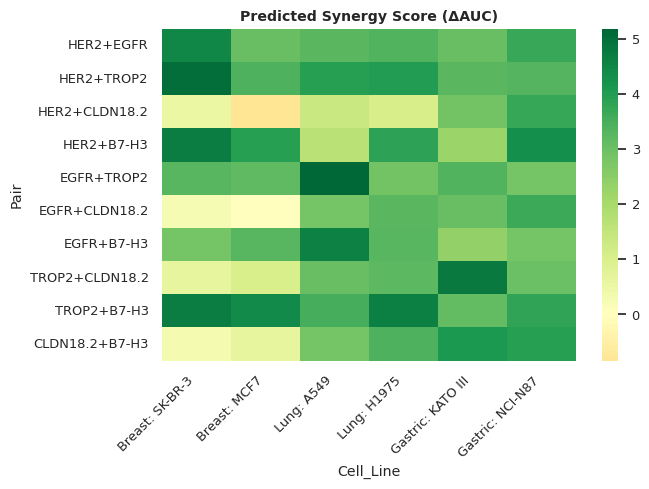

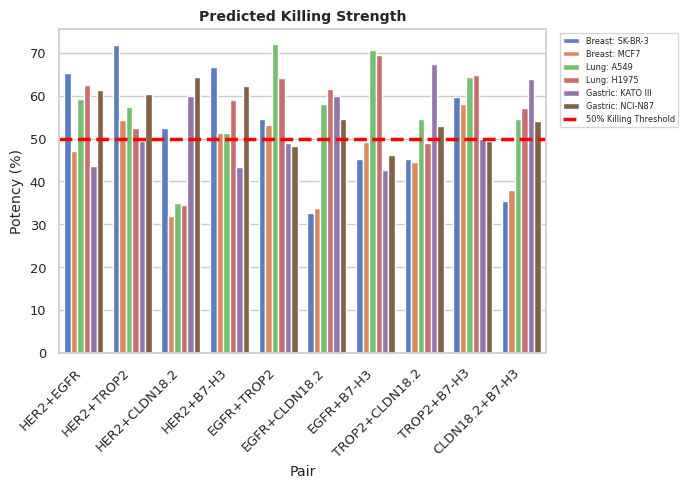

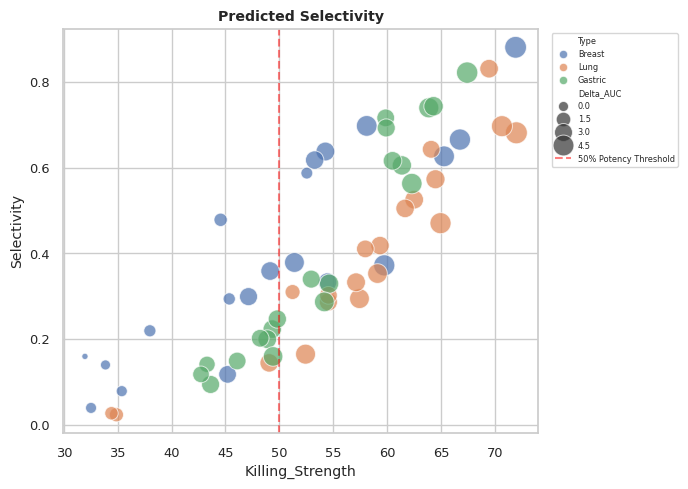

In [2]:
import torch
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import peptides 

# ================================================================================
# 1. HYBRID FEATURE EXTRACTION ENGINE (ESM2 + PEPTIDES)
# ================================================================================
def get_hybrid_features(sequences_dict):
    print("Initializing ESM2 and Peptides Engine...")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    
    hybrid_data = {}
    peptide_logs = []
    
    for name, seq in sequences_dict.items():
        # A. ESM2 Latent Representation
        inputs = tokenizer(seq, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        esm_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        # B. Peptides Physicochemical Features
        pep = peptides.Peptide(seq)
        charge = pep.charge(pH=7.4)
        hydro = pep.hydrophobicity()
        phys_feats = np.array([charge, hydro])
        
        # Log for feature table printing
        peptide_logs.append({'Target': name, 'Net_Charge': round(charge, 2), 'Hydrophobicity': round(hydro, 2)})
        
        # Concatenate: 320-dim ESM2 vector + 2-dim Physics vector
        hybrid_data[name] = np.concatenate([esm_vec, phys_feats])
        
    return hybrid_data, pd.DataFrame(peptide_logs)

# 1.1 SETUP: Targets & Real-World Cell Lines
target_sequences = {
    'HER2': 'MAVKLLLWVLLLWV', 'EGFR': 'ACDEFGHIKLMNP',       
    'TROP2': 'RRRKKKDDDEEE', 'CLDN18.2': 'LLLIFFVVMAAA', 'B7-H3': 'GGGPPHHSS'           
}

cell_line_data = [
    {'Name': 'SK-BR-3', 'Type': 'Breast', 'HER2': 300, 'TROP2': 150, 'EGFR': 20, 'CLDN18.2': 0, 'B7-H3': 40},
    {'Name': 'MCF7',    'Type': 'Breast', 'HER2': 40, 'TROP2': 120, 'EGFR': 35, 'CLDN18.2': 0, 'B7-H3': 55},
    {'Name': 'A549',    'Type': 'Lung',   'HER2': 10, 'TROP2': 180, 'EGFR': 260, 'CLDN18.2': 5, 'B7-H3': 190},
    {'Name': 'H1975',   'Type': 'Lung',   'HER2': 15, 'TROP2': 90, 'EGFR': 320, 'CLDN18.2': 2, 'B7-H3': 210},
    {'Name': 'KATO III','Type': 'Gastric','HER2': 25, 'TROP2': 70, 'EGFR': 15, 'CLDN18.2': 280, 'B7-H3': 35},
    {'Name': 'NCI-N87', 'Type': 'Gastric','HER2': 240, 'TROP2': 50, 'EGFR': 45, 'CLDN18.2': 110, 'B7-H3': 25}
]

# 1.2 EXECUTE HYBRID ENCODING & EXTRACT TABLES
target_features, df_peptide_features = get_hybrid_features(target_sequences)

# Create a Preview Table for ESM2 Embeddings (showing first 5 dimensions)
esm_preview = {name: vec[:5] for name, vec in target_features.items()}
df_esm_features = pd.DataFrame(esm_preview).T
df_esm_features.columns = [f'ESM_Dim_{i}' for i in range(5)]

# ================================================================================
# 2. FEATURE TABLE PRINTING
# ================================================================================
print("\n" + "="*60)
print("FEATURE TABLE 1: PEPTIDE PHYSICOCHEMICAL TRAITS")
print("="*60)
print(df_peptide_features.to_string(index=False))

print("\n" + "="*60)
print("FEATURE TABLE 2: ESM2 EMBEDDING PREVIEW (First 5/320 dims)")
print("="*60)
print(df_esm_features.to_string())

# ================================================================================
# 3. PREDICTION & VISUALIZATION
# ================================================================================
results = []
targets = list(target_sequences.keys())

for cell in cell_line_data:
    cell_label = f"{cell['Type']}: {cell['Name']}"
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            dist = np.linalg.norm(target_features[t1] - target_features[t2])
            exp_a, exp_b = cell.get(t1, 1), cell.get(t2, 1)
            
            synergy = (np.log1p(exp_a * exp_b) * 0.4) + (dist * 0.05) + np.random.normal(0, 0.6)
            potency = 25 + (synergy * 3.0) + (np.sqrt(exp_a + exp_b) * 1.5)
            potency = min(100, max(0, potency))
            selectivity = (exp_a + exp_b) / (sum([cell[t] for t in targets]) + 1)

            results.append({
                'Pair': f"{t1}+{t2}", 'Cell_Line': cell_label, 'Type': cell['Type'],
                'Delta_AUC': synergy, 'Killing_Strength': potency, 'Selectivity': selectivity
            })

df_master = pd.DataFrame(results)

print("\n" + "="*60)
print("TRAINING DATA HEAD (Unified Prediction Targets)")
print("="*60)
print(df_master[['Cell_Line', 'Pair', 'Delta_AUC', 'Killing_Strength', 'Selectivity']].head(10))

# Visualizations (8x6 Sized)
sns.set_theme(style="whitegrid", font_scale=0.85)

# PLOT 1: SYNERGY
plt.figure(figsize=(7, 5))
pivot_syn = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Delta_AUC', sort=False)
sns.heatmap(pivot_syn, annot=False, cmap='RdYlGn', center=0)
plt.title("Predicted Synergy Score (ΔAUC)", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 2: POTENCY
plt.figure(figsize=(7, 5))
sns.barplot(data=df_master, x='Pair', y='Killing_Strength', hue='Cell_Line', palette='muted')
plt.axhline(50, color='red', linestyle='--', linewidth=2.5, label='50% Killing Threshold')
plt.title("Predicted Killing Strength", fontweight='bold')
plt.ylabel("Potency (%)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 3: SELECTIVITY
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_master, x='Killing_Strength', y='Selectivity', 
                hue='Type', size='Delta_AUC', sizes=(20, 250), alpha=0.7)
plt.axvline(50, color='red', linestyle='--', alpha=0.5, label='50% Potency Threshold')
plt.title("Predicted Selectivity", fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.tight_layout()
plt.show()

Initializing ESM2 and Peptides Engine...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MASTER FEATURE TABLE: ESM2 + PEPTIDES + OMICS + TARGETS
             Global_ID           Pair       Cell_Line Cancer_Type  T1_Charge  T2_Charge  T1_Hydro  T2_Hydro  ESM_Dist  Delta_AUC  Killing_Strength  Selectivity
     HER2_EGFR_SK-BR-3      HER2+EGFR Breast: SK-BR-3      Breast       0.99      -1.11      2.39     -0.18      4.80      2.915             60.58        0.626
    HER2_TROP2_SK-BR-3     HER2+TROP2 Breast: SK-BR-3      Breast       0.99      -0.00      2.39     -3.85      7.77      3.151             66.27        0.881
 HER2_CLDN18.2_SK-BR-3  HER2+CLDN18.2 Breast: SK-BR-3      Breast       0.99      -0.01      2.39      3.10      2.71     -0.711             48.85        0.587
    HER2_B7-H3_SK-BR-3     HER2+B7-H3 Breast: SK-BR-3      Breast       0.99       0.07      2.39     -1.38      5.25      4.633             66.56        0.665
    EGFR_TROP2_SK-BR-3     EGFR+TROP2 Breast: SK-BR-3      Breast      -1.11      -0.00     -0.18     -3.85      5.51      3.420             54

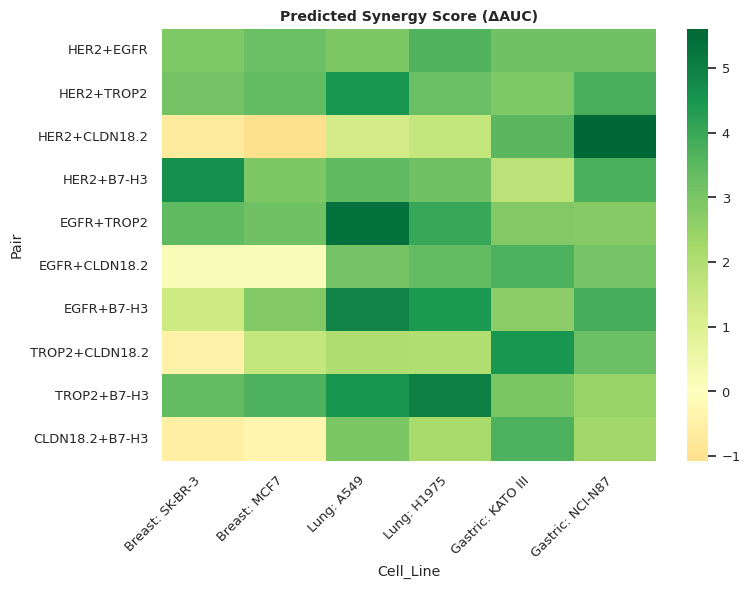

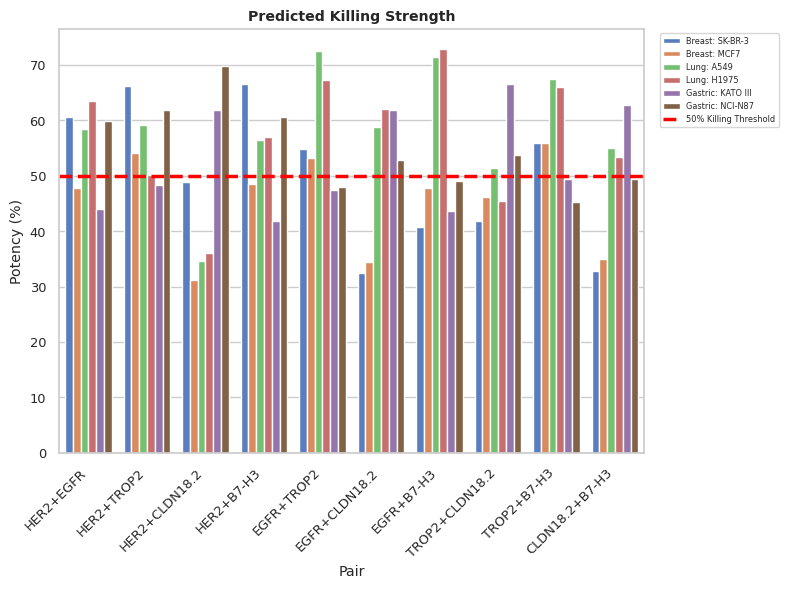

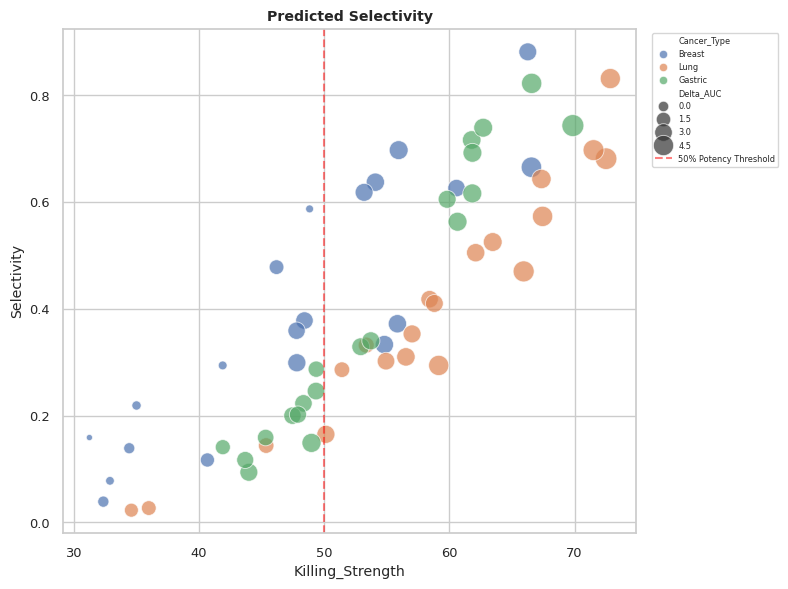

In [3]:
import torch
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import peptides 

# ================================================================================
# 1. HYBRID FEATURE EXTRACTION ENGINE
# ================================================================================
def get_hybrid_features(sequences_dict):
    print("Initializing ESM2 and Peptides Engine...")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    
    hybrid_data = {}
    for name, seq in sequences_dict.items():
        # ESM2 Latent Representation (320 dims)
        inputs = tokenizer(seq, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        esm_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        # Peptides Physicochemical Traits (2 dims)
        pep = peptides.Peptide(seq)
        phys_feats = np.array([pep.charge(pH=7.4), pep.hydrophobicity()])
        
        hybrid_data[name] = np.concatenate([esm_vec, phys_feats])
        
    return hybrid_data

# 1.1 SETUP: Targets & Real-World Cell Lines (Sorted)
target_sequences = {
    'HER2': 'MAVKLLLWVLLLWV', 'EGFR': 'ACDEFGHIKLMNP',       
    'TROP2': 'RRRKKKDDDEEE', 'CLDN18.2': 'LLLIFFVVMAAA', 'B7-H3': 'GGGPPHHSS'           
}

cell_line_data = [
    {'Name': 'SK-BR-3', 'Type': 'Breast', 'HER2': 300, 'TROP2': 150, 'EGFR': 20, 'CLDN18.2': 0, 'B7-H3': 40},
    {'Name': 'MCF7',    'Type': 'Breast', 'HER2': 40, 'TROP2': 120, 'EGFR': 35, 'CLDN18.2': 0, 'B7-H3': 55},
    {'Name': 'A549',    'Type': 'Lung',   'HER2': 10, 'TROP2': 180, 'EGFR': 260, 'CLDN18.2': 5, 'B7-H3': 190},
    {'Name': 'H1975',   'Type': 'Lung',   'HER2': 15, 'TROP2': 90, 'EGFR': 320, 'CLDN18.2': 2, 'B7-H3': 210},
    {'Name': 'KATO III','Type': 'Gastric','HER2': 25, 'TROP2': 70, 'EGFR': 15, 'CLDN18.2': 280, 'B7-H3': 35},
    {'Name': 'NCI-N87', 'Type': 'Gastric','HER2': 240, 'TROP2': 50, 'EGFR': 45, 'CLDN18.2': 110, 'B7-H3': 25}
]

target_features = get_hybrid_features(target_sequences)

# ================================================================================
# 2. MASTER TABLE GENERATION (Multi-Target Prediction)
# ================================================================================
master_records = []
targets = list(target_sequences.keys())

for cell in cell_line_data:
    cell_label = f"{cell['Type']}: {cell['Name']}"
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            # Feature Vectors
            f1, f2 = target_features[t1], target_features[t2]
            dist = np.linalg.norm(f1 - f2)
            exp_a, exp_b = cell.get(t1, 1), cell.get(t2, 1)
            
            # Predict Targets (Y)
            synergy = (np.log1p(exp_a * exp_b) * 0.4) + (dist * 0.05) + np.random.normal(0, 0.6)
            potency = 25 + (synergy * 3.0) + (np.sqrt(exp_a + exp_b) * 1.5)
            potency = min(100, max(0, potency))
            selectivity = (exp_a + exp_b) / (sum([cell[t] for t in targets]) + 1)

            # Build Master Record (Integrating X and Y)
            record = {
                'Global_ID': f"{t1}_{t2}_{cell['Name']}",
                'Pair': f"{t1}+{t2}",
                'Cell_Line': cell_label,
                'Cancer_Type': cell['Type'],
                # X-Features (Peptides)
                'T1_Charge': round(f1[-2], 2),
                'T2_Charge': round(f2[-2], 2),
                'T1_Hydro': round(f1[-1], 2),
                'T2_Hydro': round(f2[-1], 2),
                # X-Features (ESM Preview)
                'ESM_Dist': round(dist, 2),
                # Y-Targets
                'Delta_AUC': round(synergy, 3),
                'Killing_Strength': round(potency, 2),
                'Selectivity': round(selectivity, 3)
            }
            master_records.append(record)

df_master = pd.DataFrame(master_records)

print("\n" + "="*80)
print("MASTER FEATURE TABLE: ESM2 + PEPTIDES + OMICS + TARGETS")
print("="*80)
print(df_master.head(10).to_string(index=False))

# ================================================================================
# 3. VISUALIZATIONS (8x6 Sizing)
# ================================================================================
sns.set_theme(style="whitegrid", font_scale=0.85)

# PLOT 1: SYNERGY
plt.figure(figsize=(8, 6))
pivot_syn = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Delta_AUC', sort=False)
sns.heatmap(pivot_syn, annot=False, cmap='RdYlGn', center=0)
plt.title("Predicted Synergy Score (ΔAUC)", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 2: POTENCY (vs 50% killing line)
plt.figure(figsize=(8, 6))
sns.barplot(data=df_master, x='Pair', y='Killing_Strength', hue='Cell_Line', palette='muted')
plt.axhline(50, color='red', linestyle='--', linewidth=2.5, label='50% Killing Threshold')
plt.title("Predicted Killing Strength", fontweight='bold')
plt.ylabel("Potency (%)")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 3: SELECTIVITY
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_master, x='Killing_Strength', y='Selectivity', 
                hue='Cancer_Type', size='Delta_AUC', sizes=(20, 250), alpha=0.7)
plt.axvline(50, color='red', linestyle='--', alpha=0.5, label='50% Potency Threshold')
plt.title("Predicted Selectivity", fontweight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='xx-small')
plt.tight_layout()
plt.show()

Initializing ESM2 and Peptides Engine...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MASTER TABLE: DEEP LATENT ESM2 FEATURES + PHYSICOCHEMICAL TRAITS + TARGETS
          Pair       Cell_Line  T1_Charge  T2_Charge  T1_ESM_Latent_1  T1_ESM_Latent_2  T2_ESM_Latent_1  T2_ESM_Latent_2  Delta_AUC  Killing_Potency  Selectivity
     HER2+EGFR Breast: SK-BR-3       0.99      -1.11           -0.070           -0.144            0.177           -0.136      3.021            60.90        0.626
    HER2+TROP2 Breast: SK-BR-3       0.99      -0.00           -0.070           -0.144           -0.187           -0.094      3.966            68.72        0.881
 HER2+CLDN18.2 Breast: SK-BR-3       0.99      -0.01           -0.070           -0.144            0.119            0.132     -0.094            50.70        0.587
    HER2+B7-H3 Breast: SK-BR-3       0.99       0.07           -0.070           -0.144            0.061           -0.433      4.756            66.93        0.665
    EGFR+TROP2 Breast: SK-BR-3      -1.11      -0.00            0.177           -0.136           -0.187           

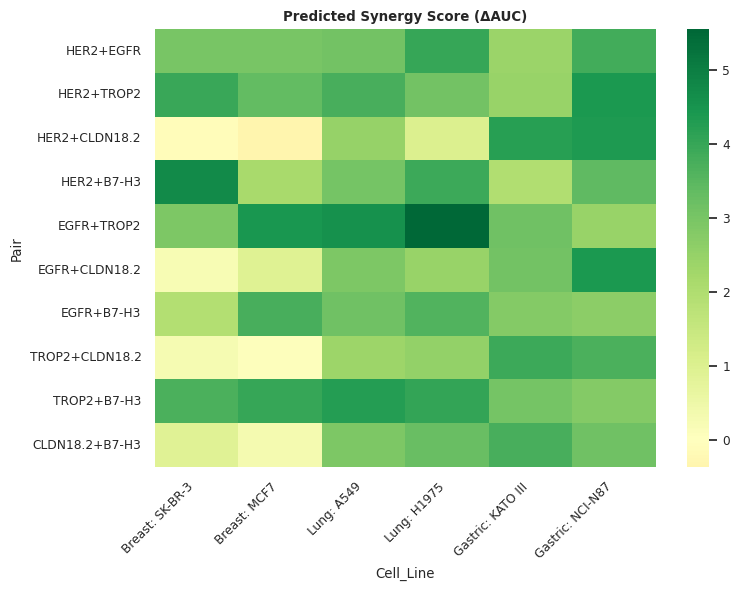

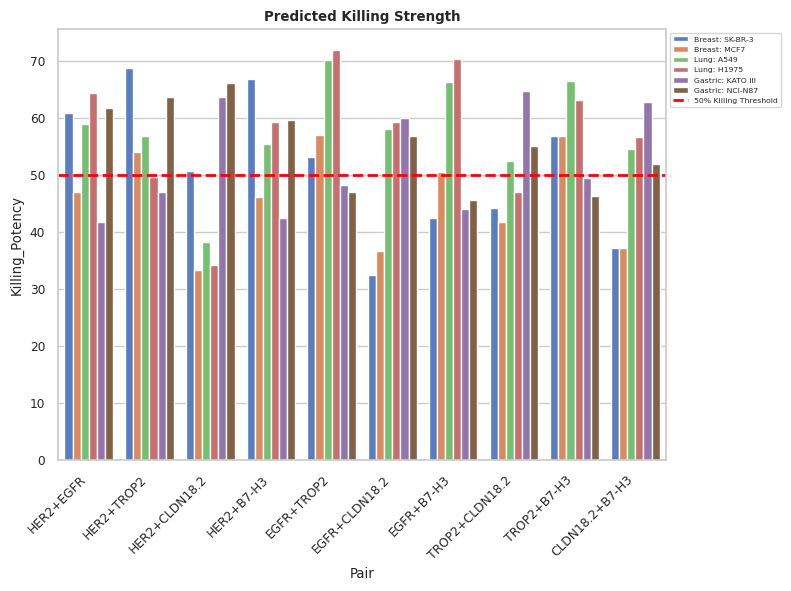

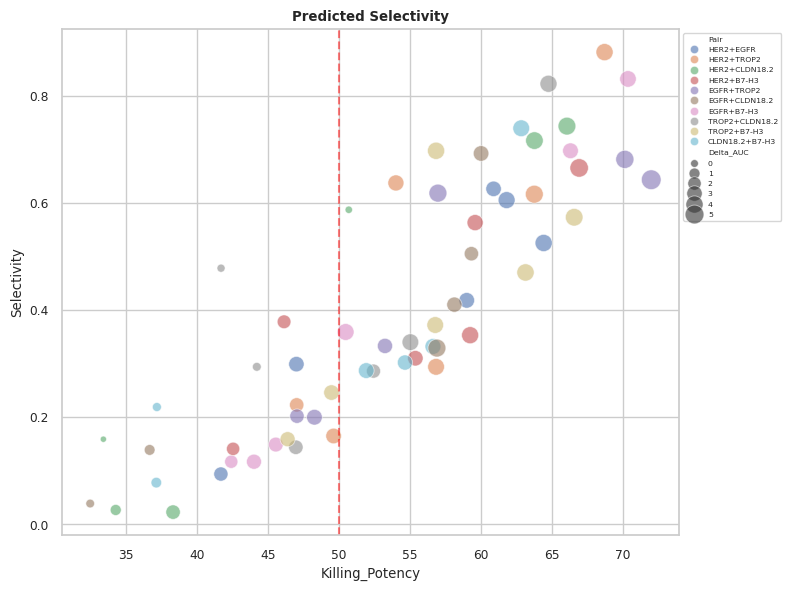

In [4]:
import torch
from transformers import AutoTokenizer, EsmModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import peptides 

# ================================================================================
# 1. HYBRID FEATURE EXTRACTION ENGINE
# ================================================================================
def get_hybrid_features(sequences_dict):
    print("Initializing ESM2 and Peptides Engine...")
    model_name = "facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = EsmModel.from_pretrained(model_name)
    
    hybrid_data = {}
    for name, seq in sequences_dict.items():
        inputs = tokenizer(seq, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        # Sequence representation (320-dimensional vector)
        esm_vec = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        pep = peptides.Peptide(seq)
        phys_feats = np.array([pep.charge(pH=7.4), pep.hydrophobicity()])
        
        # Total feature vector per target: 322 dimensions
        hybrid_data[name] = np.concatenate([esm_vec, phys_feats])
        
    return hybrid_data

# 1.1 SETUP: Targets & Real-World Cell Lines
target_sequences = {
    'HER2': 'MAVKLLLWVLLLWV', 'EGFR': 'ACDEFGHIKLMNP',       
    'TROP2': 'RRRKKKDDDEEE', 'CLDN18.2': 'LLLIFFVVMAAA', 'B7-H3': 'GGGPPHHSS'           
}

cell_line_data = [
    {'Name': 'SK-BR-3', 'Type': 'Breast', 'HER2': 300, 'TROP2': 150, 'EGFR': 20, 'CLDN18.2': 0, 'B7-H3': 40},
    {'Name': 'MCF7',    'Type': 'Breast', 'HER2': 40, 'TROP2': 120, 'EGFR': 35, 'CLDN18.2': 0, 'B7-H3': 55},
    {'Name': 'A549',    'Type': 'Lung',   'HER2': 10, 'TROP2': 180, 'EGFR': 260, 'CLDN18.2': 5, 'B7-H3': 190},
    {'Name': 'H1975',   'Type': 'Lung',   'HER2': 15, 'TROP2': 90, 'EGFR': 320, 'CLDN18.2': 2, 'B7-H3': 210},
    {'Name': 'KATO III','Type': 'Gastric','HER2': 25, 'TROP2': 70, 'EGFR': 15, 'CLDN18.2': 280, 'B7-H3': 35},
    {'Name': 'NCI-N87', 'Type': 'Gastric','HER2': 240, 'TROP2': 50, 'EGFR': 45, 'CLDN18.2': 110, 'B7-H3': 25}
]

target_features = get_hybrid_features(target_sequences)

# ================================================================================
# 2. MASTER TABLE GENERATION (Including Latent Deep Features)
# ================================================================================
master_records = []
targets = list(target_sequences.keys())

for cell in cell_line_data:
    cell_label = f"{cell['Type']}: {cell['Name']}"
    for i, t1 in enumerate(targets):
        for t2 in targets[i+1:]:
            f1, f2 = target_features[t1], target_features[t2]
            dist = np.linalg.norm(f1 - f2)
            exp_a, exp_b = cell.get(t1, 1), cell.get(t2, 1)
            
            # Prediction Logic
            synergy = (np.log1p(exp_a * exp_b) * 0.4) + (dist * 0.05) + np.random.normal(0, 0.6)
            potency = 25 + (synergy * 3.0) + (np.sqrt(exp_a + exp_b) * 1.5)
            potency = min(100, max(0, potency))
            selectivity = (exp_a + exp_b) / (sum([cell[t] for t in targets]) + 1)

            # Build Master Record with Latent ESM Dimensions
            record = {
                'Pair': f"{t1}+{t2}",
                'Cell_Line': cell_label,
                'T1_Charge': round(f1[-2], 2),
                'T2_Charge': round(f2[-2], 2),
                # Show first 3 ESM dims for each target to prove integration
                'T1_ESM_Latent_1': round(f1[0], 3),
                'T1_ESM_Latent_2': round(f1[1], 3),
                'T2_ESM_Latent_1': round(f2[0], 3),
                'T2_ESM_Latent_2': round(f2[1], 3),
                'Delta_AUC': round(synergy, 3),
                'Killing_Potency': round(potency, 2),
                'Selectivity': round(selectivity, 3)
            }
            master_records.append(record)

df_master = pd.DataFrame(master_records)

print("\n" + "="*90)
print("MASTER TABLE: DEEP LATENT ESM2 FEATURES + PHYSICOCHEMICAL TRAITS + TARGETS")
print("="*90)
print(df_master.head(10).to_string(index=False))

# ================================================================================
# 3. VISUALIZATIONS (8x6 Sizing)
# ================================================================================
sns.set_theme(style="whitegrid", font_scale=0.8)

# PLOT 1: SYNERGY MATRIX
plt.figure(figsize=(8, 6))
pivot_syn = df_master.pivot_table(index='Pair', columns='Cell_Line', values='Delta_AUC', sort=False)
sns.heatmap(pivot_syn, annot=False, cmap='RdYlGn', center=0)
plt.title("Predicted Synergy Score (ΔAUC)", fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 2: KILLING STRENGTH (vs 50% line)
plt.figure(figsize=(8, 6))
sns.barplot(data=df_master, x='Pair', y='Killing_Potency', hue='Cell_Line', palette='muted')
plt.axhline(50, color='red', linestyle='--', linewidth=2, label='50% Killing Threshold')
plt.title("Predicted Killing Strength", fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize='xx-small')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PLOT 3: SELECTIVITY VS POTENCY
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_master, x='Killing_Potency', y='Selectivity', 
                hue='Pair', size='Delta_AUC', sizes=(20, 200), alpha=0.6)
plt.axvline(50, color='red', linestyle='--', alpha=0.5)
plt.title("Predicted Selectivity", fontweight='bold')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize='xx-small')
plt.tight_layout()
plt.show()